## Inicializacion e importe de librerias

In [1]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install pydub scikit-learn wandb torchview torchviz graphviz matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install wandb

In [ ]:
!pip install torchaudio
!pip install  pydub
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import IPython
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, confusion_matrix


import wandb
wandb.login()
%matplotlib inline


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


bfbad9b2649155692b5f97a49a43c0eeb66dff4a

In [ ]:
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device

device(type='cpu')


# TP4: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




## BASE

In [ ]:
project_name='Music_genre_classification'

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [ ]:
import os
data_dir='/content/drive/MyDrive/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

In [ ]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
            fname = self.files[i]

            #img = self.transform(open_image(fpath))
            genre = parse_genres(fname)
            fpath = os.path.join(self.root,genre, fname)
            genre_index = self.classes.index(genre)
            audio = torchaudio.load(fpath)[0]

            spectogram = tt.Spectrogram(
                n_fft=1024,
            )(audio)

            hop_length=432
            n_mels=256
            n_fft = 2*(n_mels - 1)

            mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)

            return audio,spectogram, mel_spectogram, genre_index

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str
dataset = MusicDataset(data_dir)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Separamos en train y val

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

In [ ]:
audio, spectogram, mel_spectogram, class_idx = train_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,class_idx))

### 3. Visualización de los archivos

In [ ]:

waveform,spectogram, mel_spectogram,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))
# label = 9 es rock

In [ ]:

specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [ ]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
specgram.size()

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

## **Ejercicio 1**

### Autoencoder

In [ ]:

class Autoencoder_OG(nn.Module):
    def __init__(self, n_input=1, stride=16, n_channel=32):
        super(Autoencoder, self).__init__()

        # Encoder.
        self.enc_conv1 = nn.Conv1d(n_input, n_channel, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool1d(5)
        self.enc_conv2 = nn.Conv1d(n_channel, n_channel*2, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool1d(3)
        self.enc_conv3 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=3, padding=1, stride=1)

        # Decoder.
        self.dec_conv1 = nn.ConvTranspose1d(n_channel*2, n_channel*2, kernel_size=3, stride=3)
        self.dec_conv2 = nn.ConvTranspose1d(n_channel*2, n_channel, kernel_size=3, stride=5)
        self.dec_conv3 = nn.ConvTranspose1d(n_channel, n_input, kernel_size=3, stride=1)

    def forward_encoder(self, x):
        # print("Encoder input shape:", x.shape)
        x = F.tanh(self.enc_conv1(x))
        # print("Encoder Conv1 shape:", x.shape)
        x = self.pool1(x)
        # print("Encoder Pool1 shape:", x.shape)
        x = F.tanh(self.enc_conv2(x))
        # print("Encoder Conv2 shape:", x.shape)
        x = self.pool2(x)
        # print("Encoder Pool2 shape:", x.shape)
        x = F.tanh(self.enc_conv3(x))
        # print("Encoder Conv3 shape:", x.shape)
        return x

    def forward_decoder(self, x):
        x = F.tanh(self.dec_conv1(x))
        # print("Decoder Conv1 shape:", x.shape)
        x = F.tanh(self.dec_conv2(x))
        # print("Decoder Conv2 shape:", x.shape)
        x = self.dec_conv3(x) #puedo aplicar sigmoid
        # print("Decoder Conv3 shape:", x.shape)
        return x

    def forward(self, x):
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)
        return x


# Assuming your audio has shape [batch_size, channels, sequence_length]
audio_size = (batch_size, 1, 110250)  # Example shape
model = Autoencoder_OG(n_input=audio_size[1]).to(device)
# Dummy input for testing
dummy_input = torch.rand(audio_size).to(device)
output = model(dummy_input)

print("Output shape:", output.size())
print(model)

Output shape: torch.Size([20, 1, 110250])
Autoencoder(
  (enc_conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (dec_conv1): ConvTranspose1d(64, 64, kernel_size=(3,), stride=(3,))
  (dec_conv2): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(5,))
  (dec_conv3): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(1,))
)


In [ ]:
class Encoder(nn.Module):
    def __init__(self,n_input, ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv1d(n_input, ic1, kernel_size=ks1, padding=p1, stride=s1)
        self.pool1 = nn.AvgPool1d(2)
        self.conv2 = nn.Conv1d(ic1, ic2, kernel_size=ks2, padding=p2, stride=s2)
        # self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(ic2, ic3, kernel_size=ks3, padding=p3, stride=s3)

    def forward(self, x):
        print("Encoder input shape:", x.shape)
        x = F.elu(self.conv1(x))
        print("Encoder Conv1 shape:", x.shape)
        x = self.pool1(x)
        print("Encoder Pool1 shape:", x.shape)
        x = F.elu(self.conv2(x))
        print("Encoder Conv2 shape:", x.shape)
        # x = self.pool2(x)
        # print("Encoder Pool2 shape:", x.shape)
        x = F.elu(self.conv3(x))
        print("Bottle_neck shape:", x.shape)
        self.bottle_neck = x.shape
        return x

class Decoder(nn.Module):
    def __init__(self, n_input, ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3):
        super(Decoder, self).__init__()

        self.deconv3 = nn.ConvTranspose1d(ic3, ic2, kernel_size=ks3, stride=s3, padding=p3)
        self.deconv2 = nn.ConvTranspose1d(ic2, ic1, kernel_size=ks2, stride=s2, padding=p2)
        self.deconv1 = nn.ConvTranspose1d(ic1, n_input, kernel_size=ks1, stride=s1, padding=p1)

    def forward(self, x):
        x = F.elu(self.deconv3(x))
        print("Decoder Conv3 shape:", x.shape)
        x = F.elu(self.deconv2(x))
        print("Decoder Conv2 shape:", x.shape)
        x = self.deconv1(x)
        print("Decoder Conv1 shape:", x.shape)
        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bottle_neck = None

    def forward(self, x):
        x = self.encoder(x)
        self.bottle_neck = x.shape
        x = self.decoder(x)
        return x
n_input = 1
ic1 = 32
ic2 = 16
ic3 = 8

ks1 = 3
ks2 = 3
ks3 = 2

s1 = 6
s2 = 2
s3 = 2

p1 = 1
p2 = 1
p3 = 1
# Modificamos los parámetros
audio_size = (batch_size, 1, 110250)  # Ejemplo de forma
encoder = Encoder(n_input, ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3)
decoder = Decoder(n_input, ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3)
model = Autoencoder(encoder, decoder).to(device)

dummy_input = torch.rand(audio_size).to(device)
output = model(dummy_input)
print("Bottle_neck shape:", model.bottle_neck)
print("Output shape:", output.size())
print(model)

# Tamaño del output de una capa convolusional. tenemos que ajustar kernel stride y padding.
# output traspuesta = (input_size - 1) * stride - 2Padding + kernel.     1763985
# output comun = (input_size + 2p - kernel)/stride + 1.                  6891,5625

In [ ]:
'''
espacio latente: torch.Size([20, 64, 6126])
n_input = 1
ic1 = 32
ic2 = 64
ic3 = 64

ks1 = 4
ks2 = 3
ks3 = 5

s1 = 2
s2 = 3
s3 = 3

p1 = 0
p2 = 2
p3 = 2
'''

#### Entrenamos autoencoder

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

lr=0.0001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
valid_losses = []
train_accs = []
valid_accs = []

log = False


if log:
    wandb.finish()
    wandb.init(
        project=project_name,
        name=f"{model.__class__.__name__}_Bott_neck:{model.bottle_neck[1:]}",
      # trackeamos los hiperparámetros y las métricas
      config={
          "learning_rate": lr,
          "batch_size": batch_size,
          "epochs": num_epochs,
          'ic1' : ic1,
          'ic2' : ic2,
          'ic3' : ic3,
          'ks1' : ks1,
          'ks2' :ks2,
          'ks3' : ks3,
          's1' : s1,
          's2': s2,
          's3' : s3,
          'p1' : p1,
          'p2' : p2,
          'p3' : p3,
          },
    )


for epoch in range(num_epochs):
  losses = []
  train_loss = []
  val_loss = []
  # TRAIN
  model.train()
  for data in train_dl:
      audio,spectogram, mel_spectogram, genre_index = data
      audio = audio.to(device)
      # print(audio.shape)

      # Forward
      out = model(audio)
      # ?
      loss = loss_function(out.squeeze(), audio.squeeze())

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

      del spectogram #importante para ir liberando memoria ram
      del genre_index #importante para ir liberando memoria ram
      del audio #importante para ir liberando memoria ram
      del loss #importante para ir liberando memoria ram
      del out  #importante para ir liberando memoria ram
      torch.cuda.empty_cache()  #importante para ir liberando memoria ram
      gc.collect() #importante para ir liberando memoria ram

  print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(train_loss)))

  # VALIDATION
  model.eval()
  correct =0
  for data in valid_dl:
      audio,spectogram, mel_spectogram, genre_index = data
      audio = audio.to(device)
      # print(audio.shape)

      # Forward
      out = model(audio)
      # ?
      loss = loss_function(out.squeeze(), audio.squeeze())

      val_loss.append(loss.item())
      if log:
        wandb.log({
              "train_loss": np.mean(train_loss),
              "val_loss": np.mean(val_loss)})

      del spectogram #importante para ir liberando memoria ram
      del genre_index #importante para ir liberando memoria ram
      del audio #importante para ir liberando memoria ram
      del loss #importante para ir liberando memoria ram
      del out  #importante para ir liberando memoria ram
      torch.cuda.empty_cache()  #importante para ir liberando memoria ram
      gc.collect() #importante para ir liberando memoria ram

  valid_loss = np.mean(val_loss)
  print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))

  # Save model
  valid_losses.append(valid_loss.item())
  if np.argmin(valid_losses) == epoch:
      print('Saving the best model at %d epochs!' % epoch)
      torch.save(model.state_dict(), 'best_model.ckpt')
if log:
  wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.war

Epoch: [1/10], Train loss: 0.0461


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [1/10], Valid loss: 0.0404
Saving the best model at 0 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [2/10], Train loss: 0.0398


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [2/10], Valid loss: 0.0333
Saving the best model at 1 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [3/10], Train loss: 0.0317


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [3/10], Valid loss: 0.0248
Saving the best model at 2 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [4/10], Train loss: 0.0242


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [4/10], Valid loss: 0.0194
Saving the best model at 3 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [5/10], Train loss: 0.0198


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [5/10], Valid loss: 0.0162
Saving the best model at 4 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [6/10], Train loss: 0.0161


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [6/10], Valid loss: 0.0126
Saving the best model at 5 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [7/10], Train loss: 0.0117


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [7/10], Valid loss: 0.0093
Saving the best model at 6 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [8/10], Train loss: 0.0097


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [8/10], Valid loss: 0.0085
Saving the best model at 7 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [9/10], Train loss: 0.0090


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [9/10], Valid loss: 0.0080
Saving the best model at 8 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [10/10], Train loss: 0.0085


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [10/10], Valid loss: 0.0075
Saving the best model at 9 epochs!


In [ ]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for audio,spectogram, mel_spectogram, genre_index in test_dl:
        audio = audio.to(device)
        genre_index = genre_index.to(device)

        out = model(audio)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))


loaded!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [10/10], Valid loss: 0.0075


In [ ]:
original = test_dl.dataset[20]
print(original)
audio = original[0]
idnex = original[3]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,idnex))

(tensor([[-0.0052, -0.0072, -0.0025,  ...,  0.0477,  0.0456,  0.0425]]), tensor([[[1.6619e-01, 3.2325e-02, 3.4074e-01,  ..., 9.3224e-03,
          2.0081e-02, 1.2737e+00],
         [8.3387e-01, 3.6026e-01, 6.8193e-01,  ..., 7.6120e-02,
          6.6280e-02, 1.2465e+00],
         [2.3924e+00, 2.1536e-01, 1.6335e-01,  ..., 9.8128e-02,
          1.5871e-01, 3.8298e-01],
         ...,
         [1.2718e-05, 8.5327e-09, 1.3065e-09,  ..., 7.0103e-08,
          6.9704e-08, 1.4188e-06],
         [1.2698e-05, 2.0159e-08, 4.9203e-08,  ..., 7.5484e-09,
          9.3222e-08, 1.6376e-06],
         [1.3260e-05, 2.7756e-08, 7.1193e-08,  ..., 3.4183e-10,
          7.4097e-08, 1.8702e-06]]]), tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
     

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


In [ ]:
import IPython
IPython.display.Audio(audio, rate=22050)

In [ ]:
audio = audio.to(device)
print(audio.shape)

out = model(audio)

torch.Size([1, 110250])


In [ ]:
import IPython
IPython.display.Audio(out.detach().cpu(), rate=22050)

<built-in method size of Tensor object at 0x7db5ccd65260>
spectogram shape:  torch.Size([1, 1, 513, 216])
reconstructed spectogram shape:  torch.Size([1, 513, 216])

mel_spectogram shape:  torch.Size([1, 1, 256, 256])
reconstructed mel_spectogram shape:  torch.Size([1, 256, 256])
waveform shape:  torch.Size([1, 1, 110250])
waveform new shape:  torch.Size([1, 110250])
Audio Original


Audio Reconstruido


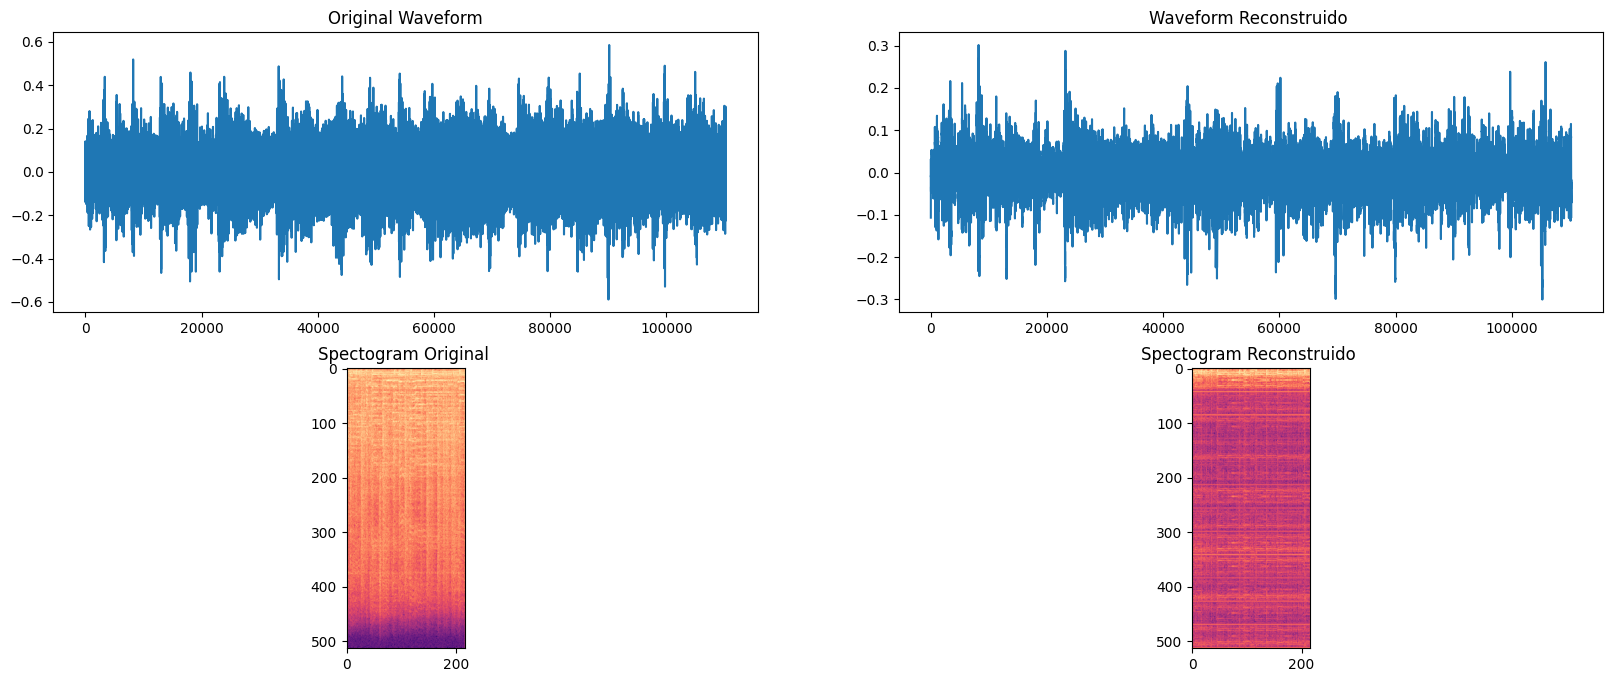

In [ ]:
model.eval()
#original
waveform, spectogram, mel_spectogram, label = next(iter(test_dl))
print(waveform.size)
audio = waveform.to(device)
spec = spectogram.to(device)
#reconstruccion
rec_audio = model(audio).to('cpu').squeeze(0).detach()
rec_spec = tt.Spectrogram(n_fft=1024)(rec_audio)

print("spectogram shape: ", spectogram.shape)
print("reconstructed spectogram shape: ", rec_spec.shape)
print()
hop_length=432
n_mels=256
n_fft = 2*(n_mels - 1)

rec_mel_spec = tt.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(rec_audio)
mel_spect = mel_spectogram.to(device)

print("mel_spectogram shape: ", mel_spect.shape)
print("reconstructed mel_spectogram shape: ", rec_mel_spec.shape)

# rec_audio = rec_audio.sAqueeze(0)

print("waveform shape: ", waveform.shape)
print("waveform new shape: ", rec_audio.shape)


fig, axs = plt.subplots(2, 2, figsize=(20, 8))

axs[0, 0].plot(audio.squeeze().detach().cpu().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_audio.t().numpy())
axs[0, 1].set_title("Waveform Reconstruido ")

axs[1, 0].imshow(spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 0].set_title("Spectogram Original ")

axs[1, 1].imshow(rec_spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 1].set_title("Spectogram Reconstruido ")

print("Audio Original")
display(IPython.display.Audio(waveform.squeeze(), rate=samplerate))
print("Audio Reconstruido")
display(IPython.display.Audio(rec_audio, rate=samplerate))